# ナンバーリンク問題

[ナンバーリンク](https://en.wikipedia.org/wiki/Numberlink)は、指定された数のペアを「途切れずに」線で結ぶパズルです。基本的なルールは以下のとおりです。  

**盤面**  
- 盤面は格子状（グリッド状）のマス目で構成されています。  
- いくつかのマスには数字が書かれています。  
- 盤面のサイズは自由ですが、例えば10×10の盤面などが一般的です。  

**目標**  
- 同じ数字が書かれた 2つのマスを線でつなぐことが目的です。  
- すべての数字のペアを正しくつなげればクリアとなります。  

**線のルール**  
- 線は上下左右にのみ進むことができます。（斜めは禁止）  
- 他の線と交差したり、枝分かれしたりしてはいけません。
- すべてのマスを埋める必要はありません。マスが空白のままでもOK）  

**クリア条件**  
以下の条件を満たせばクリアです：  
✅ すべての数字のペアが線でつながっている  
✅ 線が交差せず、分岐もない  
✅ すべての線が連続している（途切れがない）

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Numberlink_puzzle_solution.svg/300px-Numberlink_puzzle_solution.svg.png)

## 盤面の定義

本書が処理するナンバーリンクパズルの盤面は、以下のような文字列で定義されます。

- `0`は空白のマスを表し、どの数字にも属していません。  
- その他の数値（1以上の整数）はペアとなる数字を表し、対応する2つのマスを線で結ぶ必要があります。
- 16進数 (`0-9, A-F`) が使用可能で、数値が大きい場合でも2つのマスをつなぐペアとして扱われます。  

In [ ]:
puzzle="""
1000000000
0000000050
0601000000
0000043000
0000006050
0803000000
0004700000
0000002080
0700000000
0000000002
"""

まず、次のコードを使用して盤面を二次元リストに変換します。また、ループ処理をしやすくするために `enumerate_2d()` 関数を定義します。  

In [26]:
from collections import defaultdict

board = [[int(x, 16) for x in row] for row in puzzle.strip().split()]
h = len(board)
w = len(board[0])
max_value = max([max(row) for row in board])

def enumerate_2d(a):
    for r, row in enumerate(a):
        for c, v in enumerate(row):
            yield r, c, v

board

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
 [0, 6, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 4, 3, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 6, 0, 5, 0],
 [0, 8, 0, 3, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 4, 7, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 2, 0, 8, 0],
 [0, 7, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 2]]

次の `plot_board()` は、盤面 `board` とその解 `links` を描画します。`links` は辞書型で、キーは `(r1, c1, r2, c2)` の形式のタプル、値は `Bool` 値です。値が `True` の場合、マス `(r1, c1)` と `(r2, c2)` がつながっていることを意味します。

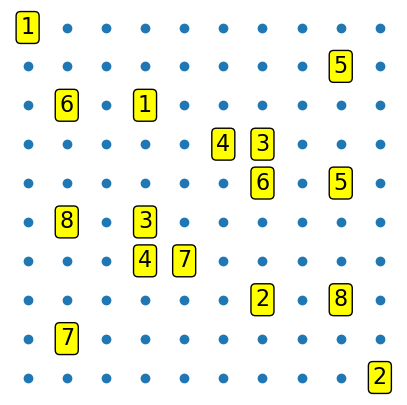

In [34]:
from matplotlib import pyplot as plt

def plot_board(board, links=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    if links is not None:
        for (r1, c1, r2, c2), link in links.items():
            if link:
                ax.plot([c1, c2], [r1, r2], color='black')
    xs = []
    ys = []
    texts = []
    for r, c, v in enumerate_2d(board):
        xs.append(c)
        ys.append(r)
        texts.append(str(v))
    
    ax.scatter(xs, ys)
    for x, y, s in zip(xs, ys, texts):
        if s != "0":
            ax.text(x, y, s, ha='center', va='center', fontsize=16, 
                    bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.2'))
    
    ax.invert_yaxis()
    ax.axis('off')
    return fig

plot_board(board);

## 解を探すコード

次のコードで解を求めます。  
- `cells` は、各マス `(r, c)` の数値を表す変数の辞書です。  
- `links` は、前述の `links` と同じ形式の辞書で、値は Z3 の `Bool` 型の変数です。  
- `cell_links` は、各マス `(r, c)` に関連する `link` を保持する辞書です。  

制約条件は以下のようです。

1. 各マスの数値は0以上かつ最大値以下でなければならない。  
2. 元々数値があるマスでは、その数値を変更しない。  
3. 元々数値があるマスの周囲のリンクには1つだけ`True`があり、その数値がルートの端点を表す。
4. 元々空白のマスの周囲のリンクにはちょうど2つの`True`があり、ルートがこのマスを通ることを意味する。
5. リンクが`True`の場合、リンクされた2つのマスの数値は等しくなければならない。  

In [35]:
from z3 import *

cells = {}
links = {}
cell_links = defaultdict(set)

for r, c, v in enumerate_2d(board):
    cells[r, c] = Int(f"C_{r}_{c}")
    r2, c2 = r, c + 1
    if c2 < w:
        links[r, c, r2, c2] = v = Bool(f"L_{r}_{c}_{r2}_{c2}")
        cell_links[r, c].add(v)
        cell_links[r2, c2].add(v)
        
    r2, c2 = r + 1, c
    if r2 < h:
        links[r, c, r2, c2] = v = Bool(f"L_{r}_{c}_{r2}_{c2}")
        cell_links[r, c].add(v)
        cell_links[r2, c2].add(v)

s = Solver()

# 各マスの数値の範囲制約
for cell in cells.values():
    s.add(0 <= cell, cell <= max_value)

for r, c, v in enumerate_2d(board):
    if v > 0:
        # 元々数値があるマスでは、その数値を変更しない
        s.add(cells[r, c] == v) 
        # 元々数値があるマスの周囲のリンクには1つだけTrue
        s.add(PbEq([(b, 1) for b in cell_links[r, c]], 1))
    else:
        # 元々空白のマスの周囲のリンクにはちょうど2つのTrue
        s.add(PbEq([(b, 1) for b in cell_links[r, c]], 2))

# リンクがある場合、マスの数値は等しくする
for (r, c, r2, c2), b in links.items():
    s.add(Implies(b, cells[r, c] == cells[r2, c2]))

s.check()
model = s.model()

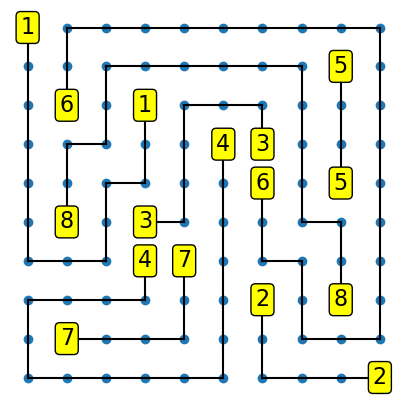

In [36]:
plot_board(board, {key:model[val] for key, val in links.items()});